In [8]:
import os
import pandas as pd
import numpy as np

import csv
import glob

combined_data = {}

metric_targets = [ "inst_per_warp", 
                  "gld_throughput", 
                  "warp_nonpred_execution_efficiency",
                  "l2_tex_read_hit_rate","ipc",
                 "l2_tex_write_transactions",
                 "inst_per_warp"]
bench_targets = [ "gaussian" ,"gemm" ]

for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gemm_results/*.csv"):
    
    filen = os.path.basename(filen_)
    
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    #metric_name = filen_split[1]
    #print(filen_split)
    size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    if not (bench_name in bench_targets): continue
    
    key_root = bench_name+"_"+size_str
    #print(key_root)
    
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        
        for line_split in fdata:
            
            lsplt = (len(line_split) > 0)

            if data_found:
                
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    mname_index = index_lookup['Metric Name']
                    metric_name = line_split[ mname_index ]
                    if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0

                    # integer value
                    if metric_name in ["l2_tex_write_transactions" ]:
                        value = int(line_split[ target_index ])
                        
                    # Labeled with percentage
                    elif metric_name in [ "warp_nonpred_execution_efficiency","l2_tex_read_hit_rate" ]:
                        # Just take the first 7 chars and convert to fraction
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif metric_name in [ "write", "read", "gld_throughput"]:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # otherwise, float
                    else:
                        value = float(line_split[ target_index ])
                    
                    # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + "_" + kernel_name
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data): 
                        combined_data [ key ] = {}
                        combined_data [ key ][ 'size' ] = int( size_str )
                    
                    # Store value for the metric being read right now
                    combined_data [ key ][ metric_name ] = value
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                    
print(combined_data)

{'gemm_128_sgemm_32x32x32_NN_vec': {'size': 128, 'inst_per_warp': 1665.0, 'warp_nonpred_execution_efficiency': 0.963363, 'gld_throughput': 51404745578.9056, 'l2_tex_read_hit_rate': 0.75, 'l2_tex_write_transactions': 2048, 'ipc': 0.521817}, 'gemm_384_sgemm_32x32x32_NN_vec': {'size': 384, 'inst_per_warp': 4121.0, 'warp_nonpred_execution_efficiency': 0.9832559999999999, 'gld_throughput': 625025115750.4, 'l2_tex_read_hit_rate': 0.9077240000000001, 'l2_tex_write_transactions': 18432, 'ipc': 1.695307}, 'gemm_256_sgemm_32x32x32_NN_vec': {'size': 256, 'inst_per_warp': 2893.0, 'warp_nonpred_execution_efficiency': 0.977531, 'gld_throughput': 311006098096.128, 'l2_tex_read_hit_rate': 0.875, 'l2_tex_write_transactions': 8192, 'ipc': 0.923787}, 'gemm_512_sgemm_32x32x32_NN_vec': {'size': 512, 'inst_per_warp': 5349.0, 'warp_nonpred_execution_efficiency': 0.986352, 'gld_throughput': 762839878860.8, 'l2_tex_read_hit_rate': 0.9364490000000001, 'l2_tex_write_transactions': 32768, 'ipc': 1.897122}, 'gemm_

                                   size  inst_per_warp  \
gemm_1024_maxwell_sgemm_128x64_nn  1024   38856.096094   
gemm_1152_maxwell_sgemm_128x64_nn  1152   29509.467284   
gemm_1280_maxwell_sgemm_128x64_nn  1280   32567.922667   
gemm_128_sgemm_32x32x32_NN_vec      128    1665.000000   
gemm_1408_maxwell_sgemm_128x64_nn  1408   35713.873967   

                                   warp_nonpred_execution_efficiency  \
gemm_1024_maxwell_sgemm_128x64_nn                           0.995702   
gemm_1152_maxwell_sgemm_128x64_nn                           0.994771   
gemm_1280_maxwell_sgemm_128x64_nn                           0.995098   
gemm_128_sgemm_32x32x32_NN_vec                              0.963363   
gemm_1408_maxwell_sgemm_128x64_nn                           0.995380   

                                   gld_throughput  l2_tex_read_hit_rate  \
gemm_1024_maxwell_sgemm_128x64_nn    5.996547e+11              0.855097   
gemm_1152_maxwell_sgemm_128x64_nn    7.203669e+11              0.855

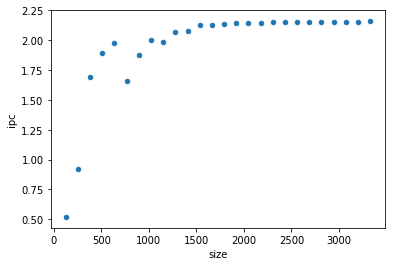

In [13]:
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data,orient="index")
print (df.head())

df.plot(x='size', y='ipc', kind='scatter')